In [95]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import SGDClassifier, SGDRegressor
import lightgbm as lgb
import joblib
from pathlib import Path
import sqlite3
from sklearn.multioutput import MultiOutputRegressor
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score

import sys

sys.path.append('C:/Users/Jordan Nishimura/NBA_Model_v1')

from src.data.process_data_no_split import get_data_from_db_all

In [97]:
connection = sqlite3.connect('../data/nba.db')
print(pd.read_sql("""SELECT name FROM sqlite_schema WHERE type='table'""", connection))
connection.close()

                          name
0                   moneylines
1         team_basic_boxscores
2      team_advanced_boxscores
3       team_scoring_boxscores
4                      spreads
5    player_tracking_boxscores
6      team_tracking_boxscores
7       team_stats_ewa_matchup
8   team_stats_ewa_matchup_dev
9  team_stats_ewa_matchup_prod


In [98]:
connection = sqlite3.connect('../data/nba.db')
team_stats_ewa_matchup_prod = pd.read_sql("""SELECT * FROM team_stats_ewa_matchup_prod""", connection)
connection.close()

In [99]:
team_stats_ewa_matchup_prod

,index,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_HOME_GAME,HOME_TEAM_SCORE,HOME_ML,HOME_SPREAD,...,AWAY_EFG_PCT_L20,AWAY_EFG_PCT_opp_L20,AWAY_AST_RATIO_L20,AWAY_AST_RATIO_opp_L20,AWAY_TOV_PCT_L20,AWAY_TOV_PCT_opp_L20,AWAY_PIE_L20,AWAY_REST,AWAY_Threein4B2B,AWAY_Threein4
0,296,2013-14,POR,2013-12-07 00:00:00,0021300298,POR vs. DAL,1,106,1.434783,-5.5,...,0.514710,0.500641,24.305035,23.174242,12.574422,14.664175,0.503846,3.0,0,0
1,298,2013-14,DET,2013-12-08 00:00:00,0021300300,DET vs. MIA,1,95,2.500000,4.0,...,0.545240,0.483274,24.820241,21.489581,15.404898,17.281397,0.555548,1.0,1,0
2,302,2013-14,CHA,2013-12-09 00:00:00,0021300304,CHA vs. GSW,1,115,3.100000,6.0,...,0.514862,0.476606,23.658670,20.646725,14.860777,13.379923,0.514737,2.0,0,1
3,303,2013-14,PHI,2013-12-09 00:00:00,0021300305,PHI vs. LAC,1,83,5.250000,10.0,...,0.498716,0.472069,26.011999,25.555622,12.926552,13.817702,0.530071,2.0,0,0
4,306,2013-14,UTA,2013-12-09 00:00:00,0021300308,UTA vs. POR,1,94,3.600000,8.0,...,0.523593,0.489991,24.703460,21.055164,13.115250,12.220492,0.544858,2.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11778,10868,2022-23,MEM,2023-02-10 00:00:00,0022200841,MEM vs. MIN,1,128,1.370370,-6.5,...,0.571406,0.542831,25.146868,24.377955,13.286664,13.463649,0.505339,2.0,0,1
11779,10869,2022-23,NOP,2023-02-10 00:00:00,0022200842,NOP vs. CLE,1,107,2.300000,3.0,...,0.581250,0.519531,30.749411,24.006900,12.455122,14.098613,0.564990,2.0,0,0
11780,10870,2022-23,POR,2023-02-10 00:00:00,0022200843,POR vs. OKC,1,129,1.609756,-3.5,...,0.562729,0.560827,24.640006,26.148986,10.788780,14.075520,0.508628,3.0,0,0
11781,10871,2022-23,SAC,2023-02-10 00:00:00,0022200844,SAC vs. DAL,1,114,1.429185,-5.0,...,0.561457,0.543847,24.088232,26.294375,11.565493,11.653611,0.490444,2.0,0,0


In [14]:
db_filepath = Path.home().joinpath('NBA_model_v1', 'data', 'nba.db')

X, y, df = get_data_from_db_all(target=['HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE'], db_filepath=db_filepath)


C:\Users\Jordan Nishimura\NBA_model_v1\data\nba.db


In [15]:
df

,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_HOME_GAME,HOME_TEAM_SCORE,HOME_ML,HOME_SPREAD,HOME_ATS_DIFF,...,AWAY_EFG_PCT_L20,AWAY_EFG_PCT_opp_L20,AWAY_AST_RATIO_L20,AWAY_AST_RATIO_opp_L20,AWAY_TOV_PCT_L20,AWAY_TOV_PCT_opp_L20,AWAY_PIE_L20,AWAY_REST,AWAY_Threein4B2B,AWAY_Threein4
0,2013-14,POR,2013-12-07 00:00:00,0021300298,POR vs. DAL,1,106,1.434783,-5.5,-7.5,...,0.514710,0.500641,24.305035,23.174242,12.574422,14.664175,0.503846,3.0,0,0
1,2013-14,DET,2013-12-08 00:00:00,0021300300,DET vs. MIA,1,95,2.500000,4.0,-11.0,...,0.545240,0.483274,24.820241,21.489581,15.404898,17.281397,0.555548,1.0,1,0
2,2013-14,CHA,2013-12-09 00:00:00,0021300304,CHA vs. GSW,1,115,3.100000,6.0,10.0,...,0.514862,0.476606,23.658670,20.646725,14.860777,13.379923,0.514737,2.0,0,1
3,2013-14,PHI,2013-12-09 00:00:00,0021300305,PHI vs. LAC,1,83,5.250000,10.0,-1.0,...,0.498716,0.472069,26.011999,25.555622,12.926552,13.817702,0.530071,2.0,0,0
4,2013-14,UTA,2013-12-09 00:00:00,0021300308,UTA vs. POR,1,94,3.600000,8.0,-3.0,...,0.523593,0.489991,24.703460,21.055164,13.115250,12.220492,0.544858,2.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11700,2022-23,PHX,2023-01-30 00:00:00,0022200762,PHX vs. TOR,1,114,1.769231,-2.0,6.0,...,0.530048,0.578025,25.353801,27.686762,9.267289,14.423265,0.502737,2.0,0,1
11695,2022-23,BKN,2023-01-30 00:00:00,0022200757,BKN vs. LAL,1,121,1.239808,-9.0,8.0,...,0.532797,0.543449,24.609814,23.855958,10.909346,10.963177,0.504193,2.0,0,0
11694,2022-23,PHI,2023-01-30 00:00:00,0022200756,PHI vs. ORL,1,109,1.210084,-10.5,-20.5,...,0.556202,0.565849,25.063560,27.363885,13.158976,12.767643,0.486009,2.0,0,1
11696,2022-23,MIN,2023-01-30 00:00:00,0022200758,MIN vs. SAC,1,111,2.150000,1.5,-5.5,...,0.590734,0.559748,27.549249,25.991463,12.361708,12.073405,0.526484,2.0,0,0


In [7]:
df.loc[df['MATCHUP'].str.contains('SAS')].sort_values('GAME_DATE')

,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_HOME_GAME,HOME_TEAM_SCORE,HOME_ML,HOME_SPREAD,HOME_ATS_DIFF,...,AWAY_EFG_PCT_L20,AWAY_EFG_PCT_opp_L20,AWAY_AST_RATIO_L20,AWAY_AST_RATIO_opp_L20,AWAY_TOV_PCT_L20,AWAY_TOV_PCT_opp_L20,AWAY_PIE_L20,AWAY_REST,AWAY_Threein4B2B,AWAY_Threein4
12,2013-14,MIL,2013-12-11 00:00:00,0021300321,MIL vs. SAS,1,77,6.900000,11.5,-20.5,...,0.569157,0.486237,27.687656,22.205756,14.218106,14.376720,0.559759,1.0,0,0
26,2013-14,SAS,2013-12-13 00:00:00,0021300338,SAS vs. MIN,1,117,1.256410,-8.0,-1.0,...,0.459629,0.538195,22.967011,23.008742,12.643351,16.794888,0.509397,2.0,0,1
37,2013-14,UTA,2013-12-14 00:00:00,0021300349,UTA vs. SAS,1,84,3.600000,7.5,-8.5,...,0.559768,0.474123,28.305114,21.852788,14.035698,13.850522,0.570402,1.0,1,0
44,2013-14,LAC,2013-12-16 00:00:00,0021300363,LAC vs. SAS,1,115,2.350000,3.5,26.5,...,0.548436,0.468694,28.310220,21.673248,13.566618,13.313255,0.573894,2.0,0,1
58,2013-14,PHX,2013-12-18 00:00:00,0021300378,PHX vs. SAS,1,101,2.450000,4.0,-3.0,...,0.550441,0.479311,27.406495,21.382536,14.276353,13.715228,0.555225,2.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11561,2022-23,MEM,2023-01-11 00:00:00,0022200623,MEM vs. SAS,1,135,1.090009,-13.5,-7.5,...,0.542633,0.572135,25.211784,24.109282,13.196351,11.987472,0.476475,2.0,0,0
11573,2022-23,SAS,2023-01-13 00:00:00,0022200635,SAS vs. GSW,1,113,3.900000,9.0,-22.0,...,0.550961,0.545491,27.024529,24.289570,13.893850,12.445051,0.486623,3.0,0,0
11590,2022-23,SAS,2023-01-15 00:00:00,0022200652,SAS vs. SAC,1,119,3.150000,7.0,-6.0,...,0.587204,0.557112,26.772899,24.792366,11.976295,12.611710,0.521690,2.0,0,0
11603,2022-23,SAS,2023-01-17 00:00:00,0022200666,SAS vs. BKN,1,106,2.150000,2.5,10.5,...,0.584084,0.515209,26.717258,22.698363,13.453719,12.131496,0.529679,2.0,0,0


In [16]:
def season_to_string(season):
    return str(season) + '-' + str(season+1)[-2:]

In [17]:
def tscv_by_season(train_df, test_season, min_training_years=2):
    earliest_year_with_data = 2013

    cv_splits = []

    for year in range(earliest_year_with_data + min_training_years, test_season+1):      
        listTrain = train_df.loc[train_df['SEASON'] < season_to_string(year)].index
        listVal = train_df.loc[train_df['SEASON'] == season_to_string(year)].index        
        cv_splits.append((listTrain, listVal))

    return cv_splits 

In [50]:
betting_df['running_mean'] = betting_df['ATS_BET_WON'].expanding().mean()
betting_df[['HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'HOME_SPREAD', 'HOME_SCORE_PRED', 
            'AWAY_SCORE_PRED', 'HOME_TEAM_COVERED', 'HOME_COVER_PRED', 'ATS_BET_WON', 'running_mean']].head(50)

betting_df.head().T

,6171,6169,6168,6167,6170
SEASON,2018-19,2018-19,2018-19,2018-19,2018-19
HOME_TEAM_ABBREVIATION,LAC,MIL,NOP,MIN,UTA
GAME_DATE,2018-10-19 00:00:00,2018-10-19 00:00:00,2018-10-19 00:00:00,2018-10-19 00:00:00,2018-10-19 00:00:00
MATCHUP,LAC vs. OKC,MIL vs. IND,NOP vs. SAC,MIN vs. CLE,UTA vs. GSW
HOME_TEAM_SCORE,108,118,149,131,123
AWAY_TEAM_SCORE,92,101,129,123,124
HOME_ML,1.666667,1.588235,1.111111,1.25,2.35
HOME_SPREAD,-3.0,-4.0,-11.5,-8.5,3.0
HOME_ATS_DIFF,13.0,13.0,8.5,-0.5,2.0
HOME_TEAM_COVERED,1.0,1.0,1.0,0.0,1.0


In [82]:
def simulate_bets(results, bet_amt):
    results = results.copy(deep=True)
    results = results.sort_values(['GAME_DATE']).reset_index(drop=True)
    results['bankroll_i'] = np.nan
    results['bankroll_n'] = np.nan
    results.loc[0, 'bankroll_i'] = 0
    for i, row in results.iterrows():
        if row['HOME_TEAM_COVERED'] == row['HOME_COVER_PRED']:
            results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] + (bet_amt/1.1)
        else:
            results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] - bet_amt
        results.at[i+1, 'bankroll_i'] = results.at[i, 'bankroll_n']
    return results            

bet_results = simulate_bets(betting_df, bet_amt=10)



In [83]:
bet_results.head(50)

,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,MATCHUP,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,HOME_ML,HOME_SPREAD,HOME_ATS_DIFF,HOME_TEAM_COVERED,...,MODEL_FAV_EQ_VEGAS_FAV,MODEL_ATS_DIFF,MODEL_ATS_DIFF_UNDER_1,MODEL_ATS_DIFF_OVER_1,MODEL_ATS_DIFF_OVER_2,MODEL_ATS_DIFF_OVER_3,MODEL_ATS_DIFF_OVER_4,running_mean,bankroll_i,bankroll_n
0,2018-19,LAC,2018-10-19 00:00:00,LAC vs. OKC,108.0,92.0,1.666667,-3.0,13.0,1.0,...,0.0,-12.924892,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000e+00,-1.000000e+01
1,2018-19,MIL,2018-10-19 00:00:00,MIL vs. IND,118.0,101.0,1.588235,-4.0,13.0,1.0,...,1.0,-2.768758,0.0,1.0,1.0,0.0,0.0,0.000000,-1.000000e+01,-2.000000e+01
2,2018-19,NOP,2018-10-19 00:00:00,NOP vs. SAC,149.0,129.0,1.111111,-11.5,8.5,1.0,...,1.0,-0.285353,1.0,0.0,0.0,0.0,0.0,0.000000,-2.000000e+01,-3.000000e+01
3,2018-19,MIN,2018-10-19 00:00:00,MIN vs. CLE,131.0,123.0,1.250000,-8.5,-0.5,0.0,...,0.0,-14.935465,0.0,1.0,1.0,1.0,1.0,0.250000,-3.000000e+01,-2.090909e+01
4,2018-19,UTA,2018-10-19 00:00:00,UTA vs. GSW,123.0,124.0,2.350000,3.0,2.0,1.0,...,1.0,-12.544627,0.0,1.0,1.0,1.0,1.0,0.200000,-2.090909e+01,-3.090909e+01
5,2018-19,TOR,2018-10-19 00:00:00,TOR vs. BOS,113.0,101.0,1.675676,-3.0,9.0,1.0,...,1.0,12.693161,0.0,1.0,1.0,1.0,1.0,0.333333,-3.090909e+01,-2.181818e+01
6,2018-19,ORL,2018-10-19 00:00:00,ORL vs. CHA,88.0,120.0,2.050000,2.0,-30.0,0.0,...,1.0,-2.353777,0.0,1.0,1.0,0.0,0.0,0.428571,-2.181818e+01,-1.272727e+01
7,2018-19,MEM,2018-10-19 00:00:00,MEM vs. ATL,131.0,117.0,1.327869,-7.0,7.0,1.0,...,0.0,-11.147178,0.0,1.0,1.0,1.0,1.0,0.375000,-1.272727e+01,-2.272727e+01
8,2018-19,BKN,2018-10-19 00:00:00,BKN vs. NYK,107.0,105.0,1.588235,-4.0,-2.0,0.0,...,1.0,0.384540,1.0,0.0,0.0,0.0,0.0,0.333333,-2.272727e+01,-3.272727e+01
9,2018-19,DAL,2018-10-20 00:00:00,DAL vs. MIN,140.0,136.0,1.769231,-2.0,2.0,1.0,...,1.0,4.940462,0.0,1.0,1.0,1.0,1.0,0.526316,-3.272727e+01,-2.363636e+01


In [87]:
def create_betting_df(test_preds, test_idx):
    
    matchup_info_cols = ['SEASON', 'HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'MATCHUP',
                        'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'HOME_ML', 'HOME_SPREAD',
                        'HOME_ATS_DIFF', 'HOME_TEAM_COVERED', 'HOME_POINT_DIFF', 'HOME_WL']

    betting_df = df[matchup_info_cols]

    betting_df = betting_df.loc[test_idx]
    betting_df[['HOME_SCORE_PRED', 'AWAY_SCORE_PRED']] = test_preds
    betting_df['HOME_SCORE_DIFF_PRED'] = betting_df['HOME_SCORE_PRED'] - betting_df['AWAY_SCORE_PRED']

    betting_df['HOME_WL_PRED'] = (betting_df['HOME_SCORE_PRED'] > betting_df['AWAY_SCORE_PRED']).astype(int)

    betting_df['HOME_FAVORED'] = (betting_df['HOME_SPREAD'] < 0).astype(int)

    betting_df['ML_BET_WON'] = (betting_df['HOME_WL_PRED'] == betting_df['HOME_WL']).astype(int)
    betting_df['HOME_COVER_PRED'] = (betting_df['HOME_SCORE_PRED'] + betting_df['HOME_SPREAD'] > betting_df['AWAY_SCORE_PRED']).astype(int)
    betting_df['ATS_BET_WON'] = (betting_df['HOME_COVER_PRED'] == betting_df['HOME_TEAM_COVERED']).astype(int)


    betting_df['BET_FAVORITE'] = (((betting_df['HOME_FAVORED'] == 1) & (betting_df['HOME_COVER_PRED'] == 1)) | ((betting_df['HOME_FAVORED'] == 0) & (betting_df['HOME_COVER_PRED'] == 0))).astype(int)

    betting_df['MODEL_FAV_EQ_VEGAS_FAV'] = (np.sign(betting_df['HOME_SPREAD']) != np.sign(betting_df['HOME_SCORE_DIFF_PRED'])).astype(int)
    betting_df['MODEL_ATS_DIFF'] = betting_df['HOME_SPREAD'] + betting_df['HOME_SCORE_DIFF_PRED']


    betting_df['MODEL_ATS_DIFF_UNDER_1'] = (betting_df['MODEL_ATS_DIFF'].abs() < 1).astype(int)
    betting_df['MODEL_ATS_DIFF_OVER_1'] = (betting_df['MODEL_ATS_DIFF'].abs() >= 1).astype(int)
    betting_df['MODEL_ATS_DIFF_OVER_2'] = (betting_df['MODEL_ATS_DIFF'].abs() >= 2).astype(int)
    betting_df['MODEL_ATS_DIFF_OVER_3'] = (betting_df['MODEL_ATS_DIFF'].abs() >= 3).astype(int)
    betting_df['MODEL_ATS_DIFF_OVER_4'] = (betting_df['MODEL_ATS_DIFF'].abs() >= 4).astype(int)
    
    betting_df.loc[betting_df['HOME_SPREAD']==0, 'HOME_FAVORED'] = np.nan
    betting_df.loc[betting_df['HOME_ATS_DIFF']==0, ['HOME_TEAM_COVERED', 'ATS_BET_WON']] = np.nan

    return betting_df

In [25]:
def simulate_bets_1(selected_bets, unit_size):
    """This function simulates betting unit_size of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index(drop=True)

    selected_bets['bankroll_i'] = np.nan
    selected_bets['bankroll_n'] = np.nan
    selected_bets['bet_size'] = np.nan

    selected_bets.at[0, 'bankroll_i'] = 100 

    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.at[idx, 'bankroll_i']):
            selected_bets.at[idx, 'bankroll_i'] = selected_bets.at[idx-1, 'bankroll_n']

        selected_bets.at[idx, 'bet_size'] = unit_size
        if selected_bets.at[idx, 'ATS_BET_WON'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.at[idx, 'bet_size']
        elif selected_bets.at[idx, 'ATS_BET_WON'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['ATS_BET_WON'] != 0.5, 'ATS_BET_WON'].mean()

    amt_won = selected_bets.loc[selected_bets['ATS_BET_WON'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['ATS_BET_WON']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked

    print("min balance:", min_balance,
            "\nmax balance:", max_balance,
            "\nfinal balance:", final_balance,
            "\nwin percentage", round(win_pct, 4) * 100,
            "\nprofit:", profit, "risk:", amt_risked,
            "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


In [21]:
cv_splits = [(df.loc[df['SEASON'] < season_to_string(season)].index, df.loc[df['SEASON'] == season_to_string(season)].index) for season in range(2018, 2023)]

In [24]:
for i, split in enumerate(cv_splits):

    X_train = X.loc[split[0]]
    y_train = y.loc[split[0]]

    X_test = X.loc[split[1]]
    y_test = y.loc[split[1]]
    
    hp_cv_splits = tscv_by_season(df.loc[X_train.index], int(df.loc[X_train.index, 'SEASON'].max()[:4]))
    
    print(X_train.index[0], X_train.index[-1], X_test.index[0], X_test.index[-1])
    print('hyperparameter training splits:')
    for s in hp_cv_splits:
        print(s[0][0], s[0][-1], s[1][0], s[1][-1])
    print('-----')

0 6162 6171 7457
hyperparameter training splits:
0 2288 2289 3579
0 3579 3580 4866
0 4866 4876 6162
-----
0 7457 7458 8571
hyperparameter training splits:
0 2288 2289 3579
0 3579 3580 4866
0 4866 4876 6162
0 6162 6171 7457
-----
0 8571 8575 9720
hyperparameter training splits:
0 2288 2289 3579
0 3579 3580 4866
0 4866 4876 6162
0 6162 6171 7457
0 7457 7458 8571
-----
0 9720 9730 10954
hyperparameter training splits:
0 2288 2289 3579
0 3579 3580 4866
0 4866 4876 6162
0 6162 6171 7457
0 7457 7458 8571
0 8571 8575 9720
-----
0 10954 10964 11701
hyperparameter training splits:
0 2288 2289 3579
0 3579 3580 4866
0 4866 4876 6162
0 6162 6171 7457
0 7457 7458 8571
0 8571 8575 9720
0 9720 9730 10954
-----


In [331]:
i=3

X_train = X.loc[cv_splits[i][0]]
y_train = y.loc[cv_splits[i][0]]

X_test = X.loc[cv_splits[i][1]]
y_test = y.loc[cv_splits[i][1]]

df.loc[X_train.index].head().T.head(20)
# df.loc[X_test.index]

,0,1,2,3,4
SEASON,2013-14,2013-14,2013-14,2013-14,2013-14
HOME_TEAM_ABBREVIATION,POR,DET,CHA,PHI,UTA
GAME_DATE,2013-12-07 00:00:00,2013-12-08 00:00:00,2013-12-09 00:00:00,2013-12-09 00:00:00,2013-12-09 00:00:00
GAME_ID,0021300298,0021300300,0021300304,0021300305,0021300308
MATCHUP,POR vs. DAL,DET vs. MIA,CHA vs. GSW,PHI vs. LAC,UTA vs. POR
HOME_HOME_GAME,1,1,1,1,1
HOME_TEAM_SCORE,106,95,115,83,94
HOME_ML,1.434783,2.5,3.1,5.25,3.6
HOME_SPREAD,-5.5,4.0,6.0,10.0,8.0
HOME_ATS_DIFF,-7.5,-11.0,10.0,-1.0,-3.0


In [78]:
for split in hp_cv_splits:
    print(split[0][0], split[0][-1], split[1][0], split[1][-1])
    
    

0 2288 2289 3579
0 3579 3580 4866
0 4866 4876 6162


Training Seasons: ['2013-14' '2014-15' '2015-16' '2016-17' '2017-18']
Testing Seasons: ['2018-19']



[I 2023-01-31 15:13:43,176] A new study created in RDB with name: C:\Users\Jordan Nishimura\NBA_model_v1\models\hyperparameter_tuning\SGDRegressor_ScorePredictor_backtest0
[I 2023-01-31 15:15:38,701] Trial 0 finished with value: -12.090773246091217 and parameters: {'alpha': 19.78492122663924, 'l1_ratio': 0.7167458585033812}. Best is trial 0 with value: -12.090773246091217.


average score in cross-validation: -12.090773246091217


[I 2023-01-31 15:17:32,331] Trial 1 finished with value: -12.090773246091217 and parameters: {'alpha': 0.11399900782106884, 'l1_ratio': 0.5477458731374525}. Best is trial 0 with value: -12.090773246091217.


average score in cross-validation: -12.090773246091217


[I 2023-01-31 15:19:29,878] Trial 2 finished with value: -9.235667811981076 and parameters: {'alpha': 0.002173310070818879, 'l1_ratio': 0.6948187805493663}. Best is trial 2 with value: -9.235667811981076.


average score in cross-validation: -9.235667811981076


[I 2023-01-31 15:21:26,491] Trial 3 finished with value: -12.090773246091217 and parameters: {'alpha': 17.21526215645873, 'l1_ratio': 0.40959405160792045}. Best is trial 2 with value: -9.235667811981076.


average score in cross-validation: -12.090773246091217


[I 2023-01-31 15:23:28,845] Trial 4 finished with value: -12.090773246091217 and parameters: {'alpha': 0.007367323792183618, 'l1_ratio': 0.861675660124461}. Best is trial 2 with value: -9.235667811981076.


average score in cross-validation: -12.090773246091217
params: {'alpha': 0.002173310070818879, 'l1_ratio': 0.6948187805493663}

train_mae: 7.812700258449972
test_mae: 8.700972425034408

betting results on testing season:


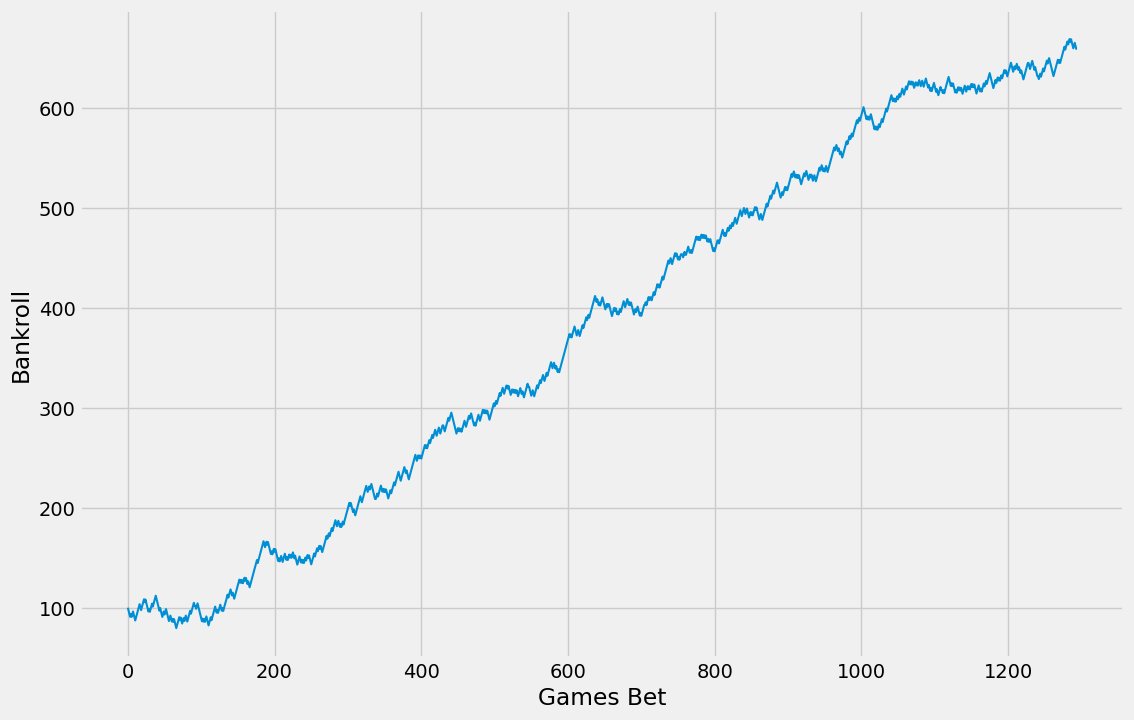

min balance: 79.54545454545475 
max balance: 669.1818181818285 
final balance: 656.3636363636467 
win percentage 60.0 
profit: 556.363636363636 risk: 3885.0 
ROI: 14.32
roi: 0.14320814320814312 profit: 556.363636363636 win_pct: 0.6



In [26]:
for i, split in enumerate(cv_splits[:1]):
    X_train = X.loc[split[0]]
    y_train = y.loc[split[0]]

    X_test = X.loc[split[1]]
    y_test = y.loc[split[1]]
    hp_cv_splits = tscv_by_season(df.loc[X_train.index], int(df.loc[X_train.index, 'SEASON'].max()[:4]))

    print("Training Seasons:", df.loc[split[0], 'SEASON'].unique())
    print("Testing Seasons:", df.loc[split[1], 'SEASON'].unique())
    print()

    def objective(trial):
        
        sgd_alpha = trial.suggest_float('alpha', 1e-4, 1e2, log=True)
        sgd_l1_ratio = trial.suggest_float('l1_ratio', 0.4, 0.95, log=False)
        # sgd_epsilon = trial.suggest_float('epsilon', 5, 25, log=False)
        # sgd_loss = trial.suggest_categorical('loss', ['huber'])
            
        regressor_obj = Pipeline([('scaler', StandardScaler()),
                                    ('sgd', MultiOutputRegressor(
                                                SGDRegressor(loss = 'huber',
                                                            alpha = sgd_alpha,
                                                            # epsilon = sgd_epsilon,
                                                            penalty = 'elasticnet',
                                                            max_iter = 10000,
                                                            l1_ratio = sgd_l1_ratio,
                                                            shuffle = False,
                                                            random_state = 23)
                                                )
                                    )
                                    ]
                                )
        

        for split in hp_cv_splits:
            print(split[0][0], split[0][-1], split[1][0], split[1][-1])
        score = cross_val_score(regressor_obj, X_train, y_train, cv = hp_cv_splits, scoring = 'neg_mean_absolute_error', error_score='raise')
        
        score_avg = score.mean()
        print("average score in cross-validation:", score_avg)
        return score_avg



    db_filepath = Path.home().joinpath('NBA_model_v1', 'data', 'nba.db')
    hyperparameter_filepath_out = Path.home().joinpath('NBA_model_v1', 'models', 'hyperparameter_tuning')

    n_trials = 5
    random_state = 23
    model_name = 'SGDRegressor_ScorePredictor_backtest' + str(i)
    study_name = str(Path.home().joinpath('NBA_model_v1', 'models', 'hyperparameter_tuning', model_name))
    storage_name = "sqlite:///{}.db".format(study_name)
        
    study = optuna.create_study(study_name = study_name, direction='maximize', 
                                storage = storage_name, load_if_exists=True)

    study.optimize(objective, n_trials=n_trials)

    params = study.best_params
    
    print("params:", params)
    print()

    best_model = Pipeline([('scaler', StandardScaler()),
                                ('sgd', MultiOutputRegressor(SGDRegressor(**params,                                                                
                                                                shuffle=False,
                                                                random_state=23)))])

    best_model.fit(X_train, y_train)


    # Make Predictions   
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    
    print("train_mae:", mean_absolute_error(y_train, train_preds))
    print("test_mae:", mean_absolute_error(y_test, test_preds))  

    print()

    betting_df = create_betting_df(test_preds, i)
    
    print("betting results on testing season:")
    result_df, roi, profit, win_pct = simulate_bets_1(selected_bets = betting_df, unit_size=3)
    
    print("roi:", roi, "profit:", profit, "win_pct:", win_pct)
    print()

In [337]:
result_df.loc[result_df['GAME_DATE'] == '2023-01-07', ['SEASON', 'GAME_DATE', 'MATCHUP', 'HOME_SPREAD', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 
           'HOME_SCORE_PRED', 'AWAY_SCORE_PRED', 'HOME_FAVORED','BET_FAVORITE', 'HOME_COVER_PRED', 
           'HOME_TEAM_COVERED', 'ATS_BET_WON', 'bankroll_i', 'bankroll_n']]

selected_bets = result_df.loc[result_df['GAME_DATE']>='2022-12-12']

In [86]:
X_train = X.loc[df['SEASON'] <= '2019-2020']
X_test = X.loc[df['SEASON'] > '2019-2020']
y_train = y.loc[df['SEASON'] <= '2019-2020']
y_test = y.loc[df['SEASON'] > '2019-2020']

In [89]:
best_model.fit(X_train, y_train)

test_preds = best_model.predict(X_test)



betting_df = create_betting_df(test_preds, df.loc[df['SEASON']>'2019-2020'].index)

In [94]:
betting_df[['SEASON', 'GAME_DATE', 'MATCHUP', 'HOME_SPREAD', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 
           'HOME_SCORE_PRED', 'AWAY_SCORE_PRED', 'HOME_FAVORED','BET_FAVORITE', 'HOME_COVER_PRED', 
           'HOME_TEAM_COVERED', 'ATS_BET_WON']]

,SEASON,GAME_DATE,MATCHUP,HOME_SPREAD,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,HOME_SCORE_PRED,AWAY_SCORE_PRED,HOME_FAVORED,BET_FAVORITE,HOME_COVER_PRED,HOME_TEAM_COVERED,ATS_BET_WON
8575,2020-21,2020-12-25 00:00:00,LAL vs. DAL,-6.5,138,115,117.703177,110.384505,1.0,1,1,1.0,1.0
8574,2020-21,2020-12-25 00:00:00,BOS vs. BKN,3.5,95,123,120.719024,114.837775,0.0,0,1,0.0,0.0
8576,2020-21,2020-12-25 00:00:00,DEN vs. LAC,4.0,108,121,107.866453,107.645909,0.0,0,1,0.0,0.0
8572,2020-21,2020-12-25 00:00:00,MIA vs. NOP,-3.0,111,98,103.302844,103.831117,1.0,0,0,1.0,0.0
8573,2020-21,2020-12-25 00:00:00,MIL vs. GSW,-10.0,138,99,118.989090,108.861287,1.0,1,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11700,2022-23,2023-01-30 00:00:00,PHX vs. TOR,-2.0,114,106,111.202554,114.018182,1.0,0,0,1.0,0.0
11695,2022-23,2023-01-30 00:00:00,BKN vs. LAL,-9.0,121,104,116.161996,106.984310,1.0,1,1,1.0,1.0
11694,2022-23,2023-01-30 00:00:00,PHI vs. ORL,-10.5,109,119,111.570569,107.404583,1.0,0,0,0.0,1.0
11696,2022-23,2023-01-30 00:00:00,MIN vs. SAC,1.5,111,118,108.445359,122.097028,0.0,1,0,0.0,1.0


,feature_name,coef
189,HOME_FG2A_L20,-3.451205
445,AWAY_UFGA_opp_L10,-3.146358
193,HOME_FTA_L20,-3.002963
104,HOME_BLK_L10,-2.295163
492,AWAY_RBC_L20,-2.213249
...,...,...
28,HOME_DFGM_L5,2.229776
87,HOME_EFG_PCT_L5,2.457845
2,HOME_FG3M_L5,2.814757
94,HOME_FG2M_L10,3.445260


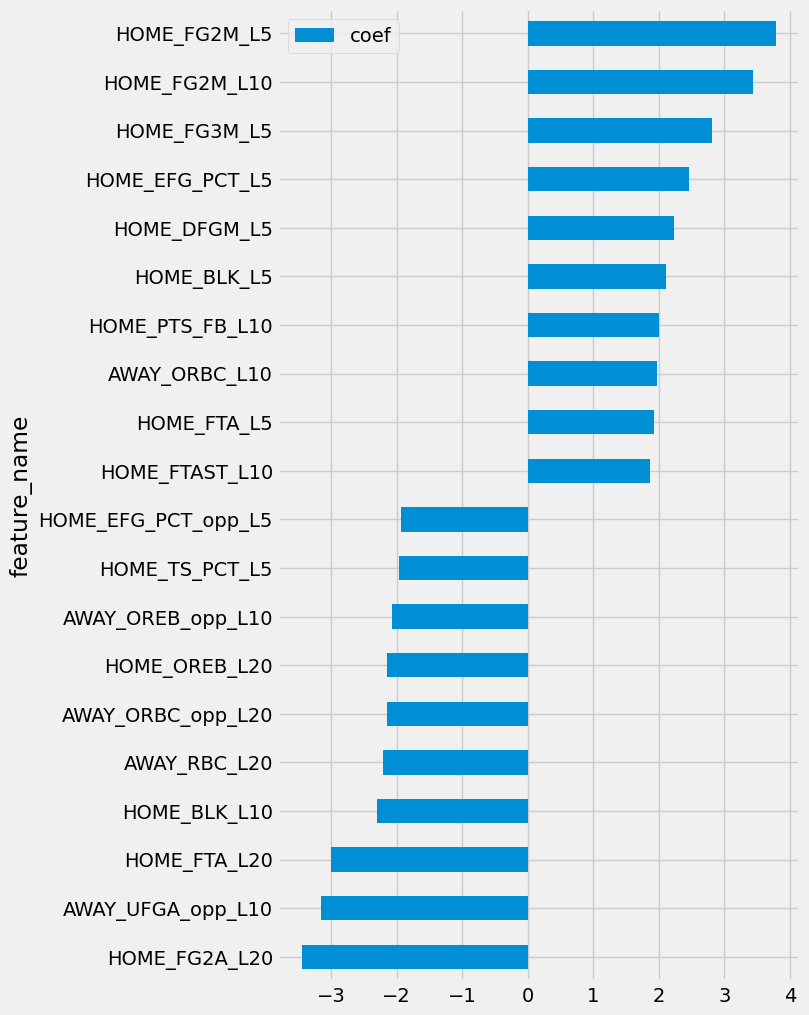

In [80]:
def view_model_coefs(model, X_train, plot_graph = True, remove_zero_coefs=True):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})
    if remove_zero_coefs:
        coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    if plot_graph:
        top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
        top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df

view_model_coefs(best_model.named_steps['sgd'].estimators_[0], X_train)

In [345]:
train_idx = df.loc[df['SEASON'] < '2019-20'].index
test_idx = df.loc[df['SEASON'] >= '2019-20'].index

X_train = X.loc[train_idx]
y_train = y.loc[train_idx]

X_test = X.loc[test_idx]
y_test = y.loc[test_idx]


params = {'alpha': 0.20014548177222843, 'epsilon': 23.529079155386505, 'l1_ratio': 0.842464243443114, 'loss': 'huber'}

best_model = Pipeline([('scaler', StandardScaler()),
                            ('sgd', MultiOutputRegressor(SGDRegressor(**params,                                                                
                                                            shuffle=False,
                                                            random_state=23)))])

best_model.fit(X_train, y_train)


# Make Predictions   
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

print("train_mae:", mean_absolute_error(y_train, train_preds))
print("test_mae:", mean_absolute_error(y_test, test_preds))  

print()



train_mae: 8.04123720198765
test_mae: 8.766890180940582



In [357]:
pd.options.display.max_rows=200
df.loc[df['MATCHUP'].str.contains('UTA'), ['HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'HOME_POINT_DIFF', 'HOME_WL', 'HOME_WIN_PCT_L5', 'AWAY_WIN_PCT_L5', 'HOME_WIN_PCT_L10', 'AWAY_WIN_PCT_L10',]].tail(15)

,HOME_TEAM_ABBREVIATION,GAME_DATE,HOME_POINT_DIFF,HOME_WL,HOME_WIN_PCT_L5,AWAY_WIN_PCT_L5,HOME_WIN_PCT_L10,AWAY_WIN_PCT_L10
11323,UTA,2022-12-09 00:00:00,-10,0,0.6,0.4,0.4,0.6
11331,DEN,2022-12-10 00:00:00,5,1,0.4,0.6,0.6,0.3
11350,UTA,2022-12-13 00:00:00,21,1,0.4,1.0,0.3,0.9
11364,UTA,2022-12-15 00:00:00,3,1,0.4,0.8,0.4,0.8
11380,MIL,2022-12-17 00:00:00,26,1,0.6,0.6,0.7,0.5
11390,CLE,2022-12-19 00:00:00,23,1,0.8,0.4,0.7,0.5
11399,DET,2022-12-20 00:00:00,-15,0,0.2,0.4,0.3,0.5
11416,UTA,2022-12-22 00:00:00,8,1,0.6,0.2,0.5,0.1
11441,SAS,2022-12-26 00:00:00,4,1,0.2,0.6,0.4,0.5
11459,GSW,2022-12-28 00:00:00,5,1,0.6,0.4,0.4,0.5


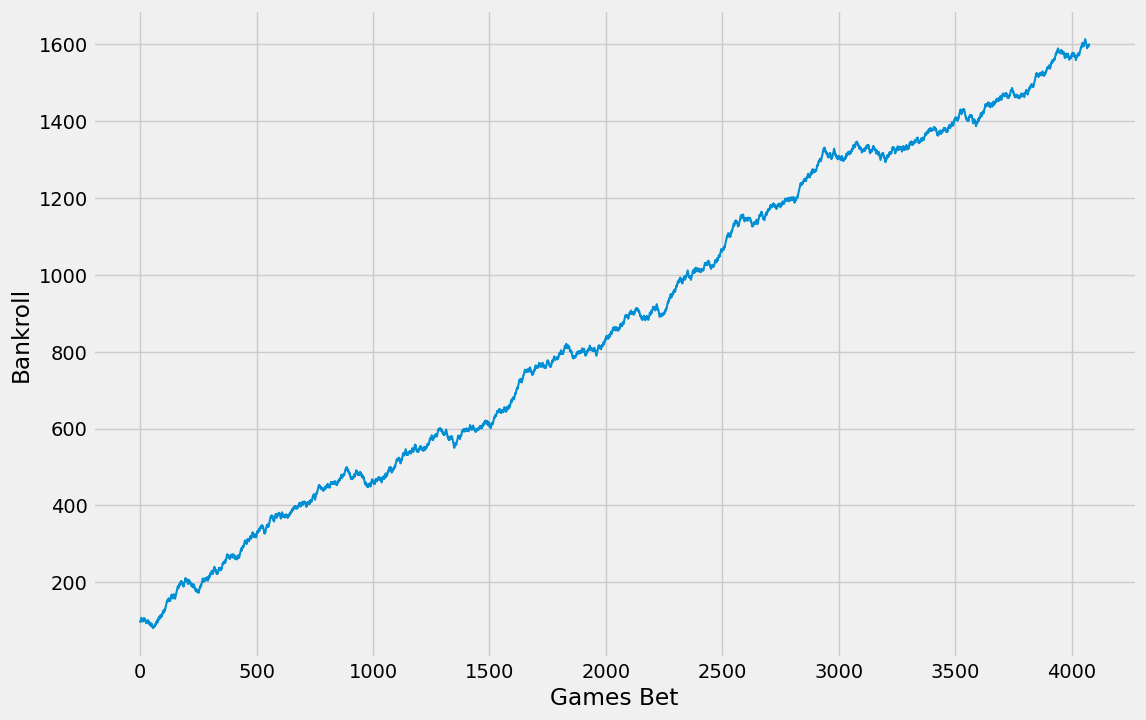

min balance: 81.18181818181834 
max balance: 1612.5454545454977 
final balance: 1598.636363636407 
win percentage 58.919999999999995 
profit: 1498.636363636363 risk: 12228.0 
ROI: 12.26


In [346]:
matchup_info_cols = ['SEASON', 'HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'MATCHUP',
                    'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'HOME_ML', 'HOME_SPREAD',
                    'HOME_ATS_DIFF', 'HOME_TEAM_COVERED', 'HOME_POINT_DIFF', 'HOME_WL']

betting_df = df[matchup_info_cols]

betting_df = betting_df.loc[test_idx]
betting_df[['HOME_SCORE_PRED', 'AWAY_SCORE_PRED']] = test_preds
betting_df['HOME_SCORE_DIFF_PRED'] = betting_df['HOME_SCORE_PRED'] - betting_df['AWAY_SCORE_PRED']

betting_df['HOME_WL_PRED'] = (betting_df['HOME_SCORE_PRED'] > betting_df['AWAY_SCORE_PRED']).astype(int)

betting_df['HOME_FAVORED'] = (betting_df['HOME_SPREAD'] < 0).astype(int)

betting_df['ML_BET_WON'] = (betting_df['HOME_WL_PRED'] == betting_df['HOME_WL']).astype(int)
betting_df['HOME_COVER_PRED'] = (betting_df['HOME_SCORE_PRED'] + betting_df['HOME_SPREAD'] > betting_df['AWAY_SCORE_PRED']).astype(int)
betting_df['ATS_BET_WON'] = (betting_df['HOME_COVER_PRED'] == betting_df['HOME_TEAM_COVERED']).astype(int)


betting_df['BET_FAVORITE'] = (((betting_df['HOME_FAVORED'] == 1) & (betting_df['HOME_COVER_PRED'] == 1)) | ((betting_df['HOME_FAVORED'] == 0) & (betting_df['HOME_COVER_PRED'] == 0))).astype(int)

betting_df['MODEL_FAV_EQ_VEGAS_FAV'] = (np.sign(betting_df['HOME_SPREAD']) != np.sign(betting_df['HOME_SCORE_DIFF_PRED'])).astype(int)
betting_df['MODEL_ATS_DIFF'] = betting_df['HOME_SPREAD'] + betting_df['HOME_SCORE_DIFF_PRED']


betting_df['MODEL_ATS_DIFF_UNDER_1'] = (betting_df['MODEL_ATS_DIFF'].abs() < 1).astype(int)
betting_df['MODEL_ATS_DIFF_OVER_1'] = (betting_df['MODEL_ATS_DIFF'].abs() >= 1).astype(int)
betting_df['MODEL_ATS_DIFF_OVER_2'] = (betting_df['MODEL_ATS_DIFF'].abs() >= 2).astype(int)
betting_df['MODEL_ATS_DIFF_OVER_3'] = (betting_df['MODEL_ATS_DIFF'].abs() >= 3).astype(int)
betting_df['MODEL_ATS_DIFF_OVER_4'] = (betting_df['MODEL_ATS_DIFF'].abs() >= 4).astype(int)

betting_df.loc[betting_df['HOME_SPREAD']==0, 'HOME_FAVORED'] = np.nan
betting_df.loc[betting_df['HOME_ATS_DIFF']==0, ['HOME_TEAM_COVERED', 'ATS_BET_WON']] = np.nan

    
result_df, roi, profit, win_pct = simulate_bets_1(selected_bets = betting_df, unit_size=3)




In [286]:
betting_df.groupby(['MODEL_FAV_EQ_VEGAS_FAV', 'HOME_COVER_PRED', 'BET_FAVORITE', 'HOME_WL_PRED', 'MODEL_ATS_DIFF_OVER_3'])['ATS_BET_WON'].agg(('sum', 'count', 'mean'))

sum  \
MODEL_FAV_EQ_VEGAS_FAV HOME_COVER_PRED BET_FAVORITE HOME_WL_PRED MODEL_ATS_DIFF_OVER_3         
0                      0               0            0            0                       1.0   
                                                                 1                      37.0   
                       1               0            1            0                       2.0   
                                                                 1                      72.0   
1                      0               0            1            0                      31.0   
                                                                 1                      34.0   
                                       1            0            0                       8.0   
                                                                 1                      22.0   
                       1               0            0            0                      18.0   
                                                                 1                      20.0   
                                       1            1            0                      27.0   
                                                                 1                      78.0   

                                                                                        count  \
MODEL_FAV_EQ_VEGAS_FAV HOME_COVER_PRED BET_FAVORITE HOME_WL_PRED MODEL_ATS_DIFF_OVER_3          
0                      0               0            0            0                          5   
                                                                 1                         55   
                       1               0            1            0                          6   
                                                                 1                        108   
1                      0               0            1            0                         58   
                                                                 1                         51   
                                       1            0            0                         18   
                                                                 1                         35   
                       1               0            0            0                         30   
                                                                 1                         23   
                                       1            1            0                         55   
                                                                 1                        123   

                                                                                            mean  
MODEL_FAV_EQ_VEGAS_FAV HOME_COVER_PRED BET_FAVORITE HOME_WL_PRED MODEL_ATS_DIFF_OVER_3            
0                      0               0            0            0                      0.200000  
                                                                 1                      0.672727  
                       1               0            1            0                      0.333333  
                                                                 1                      0.666667  
1                      0               0            1            0                      0.534483  
                                                                 1                      0.666667  
                                       1            0            0                      0.444444  
                                                                 1                      0.628571  
                       1               0            0            0                      0.600000  
                                                                 1                      0.869565  
                                       1            1            0                      0.490909  
                                                                 1                      0.634146

In [279]:
betting_df.loc[betting_df['GAME_DATE'].between('2022-10-19', '2023-01-07'), ['HOME_COVER_PRED', 'HOME_TEAM_COVERED', 'ATS_BET_WON']].sum()

HOME_COVER_PRED      351.0
HOME_TEAM_COVERED    303.0
ATS_BET_WON          347.0
dtype: float64

In [275]:
betting_df.loc[betting_df['GAME_DATE'].between('2022-10-19', '2023-01-07'), ['HOME_COVER_PRED', 'ATS_BET_WON']].mean()

HOME_COVER_PRED    0.611498
ATS_BET_WON        0.617438
dtype: float64

In [276]:
betting_df

,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,MATCHUP,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,HOME_ML,HOME_SPREAD,HOME_ATS_DIFF,HOME_TEAM_COVERED,...,HOME_COVER_PRED,ATS_BET_WON,BET_FAVORITE,MODEL_FAV_EQ_VEGAS_FAV,MODEL_ATS_DIFF,MODEL_ATS_DIFF_UNDER_1,MODEL_ATS_DIFF_OVER_1,MODEL_ATS_DIFF_OVER_2,MODEL_ATS_DIFF_OVER_3,MODEL_ATS_DIFF_OVER_4
10965,2022-23,POR,2022-10-21 00:00:00,POR vs. PHX,113,111,2.800000,5.5,7.5,1.0,...,0,0.0,1,1,-14.337130,0,1,1,1,1
10964,2022-23,GSW,2022-10-21 00:00:00,GSW vs. DEN,123,128,1.444444,-6.0,-11.0,0.0,...,0,1.0,0,1,-0.798551,1,0,0,0,0
10963,2022-23,MIN,2022-10-21 00:00:00,MIN vs. UTA,126,132,1.285714,-8.0,-14.0,0.0,...,0,1.0,0,1,-1.269603,0,1,0,0,0
10961,2022-23,NYK,2022-10-21 00:00:00,NYK vs. DET,130,106,1.280112,-7.5,16.5,1.0,...,0,0.0,0,1,-2.203361,0,1,1,0,0
10960,2022-23,MIA,2022-10-21 00:00:00,MIA vs. BOS,104,111,2.260000,3.5,-3.5,0.0,...,1,0.0,0,1,2.892385,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11531,2022-23,DAL,2023-01-07 00:00:00,DAL vs. NOP,127,117,1.239808,-9.0,1.0,1.0,...,0,0.0,0,1,-4.083417,0,1,1,1,1
11532,2022-23,GSW,2023-01-07 00:00:00,GSW vs. ORL,101,115,1.377358,-7.0,-21.0,0.0,...,0,1.0,0,0,-8.559562,0,1,1,1,1
11529,2022-23,SAS,2023-01-07 00:00:00,SAS vs. BOS,116,121,9.500000,15.5,10.5,1.0,...,1,1.0,0,1,11.614654,0,1,1,1,1
11530,2022-23,CHI,2023-01-07 00:00:00,CHI vs. UTA,126,118,2.230000,3.0,11.0,1.0,...,0,0.0,1,1,-4.304485,0,1,1,1,1


In [241]:
betting_df[['SEASON', 'GAME_DATE', 'MATCHUP', 'HOME_SPREAD', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'HOME_SCORE_PRED', 'AWAY_SCORE_PRED', 'HOME_FAVORED','BET_FAVORITE', 'HOME_COVER_PRED', 'HOME_TEAM_COVERED', 'ATS_BET_WON']].head(15)

,SEASON,GAME_DATE,MATCHUP,HOME_SPREAD,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,HOME_SCORE_PRED,AWAY_SCORE_PRED,HOME_FAVORED,BET_FAVORITE,HOME_COVER_PRED,HOME_TEAM_COVERED,ATS_BET_WON
7466,2019-20,2019-10-25 00:00:00,LAL vs. UTA,-4.0,95,86,106.218683,114.412288,1.0,0,0,1.0,0.0
7465,2019-20,2019-10-25 00:00:00,SAC vs. POR,2.0,112,122,105.514631,116.165659,0.0,1,0,0.0,1.0
7464,2019-20,2019-10-25 00:00:00,DEN vs. PHX,-12.0,108,107,115.061047,104.872937,1.0,0,0,0.0,1.0
7463,2019-20,2019-10-25 00:00:00,OKC vs. WAS,-9.0,85,97,114.788994,108.217446,1.0,0,0,0.0,1.0
7460,2019-20,2019-10-25 00:00:00,BKN vs. NYK,-8.0,113,109,107.994317,103.431937,1.0,0,0,0.0,1.0
7461,2019-20,2019-10-25 00:00:00,MEM vs. CHI,2.5,102,110,114.576760,110.752654,0.0,0,1,0.0,0.0
7459,2019-20,2019-10-25 00:00:00,CHA vs. MIN,5.5,99,121,109.774938,108.749742,0.0,0,1,0.0,0.0
7458,2019-20,2019-10-25 00:00:00,BOS vs. TOR,-3.0,112,106,106.598974,104.632365,1.0,0,0,1.0,0.0
7462,2019-20,2019-10-25 00:00:00,NOP vs. DAL,-2.0,116,123,108.072438,115.813464,1.0,0,0,0.0,1.0
7474,2019-20,2019-10-26 00:00:00,SAS vs. WAS,-11.5,124,122,117.589255,108.299831,1.0,0,0,0.0,1.0


In [246]:
betting_df[['HOME_FAVORED', 'BET_FAVORITE', 'HOME_COVER_PRED', 'HOME_TEAM_COVERED', 'ML_BET_WON', 'ATS_BET_WON']].mean()

HOME_FAVORED         0.595041
BET_FAVORITE         0.346499
HOME_COVER_PRED      0.308797
HOME_TEAM_COVERED    0.491276
ML_BET_CORRECT       0.682226
ATS_BET_WON          0.591368
dtype: float64

In [15]:
def simulate_bets_1(selected_bets, unit_size):
    """This function simulates betting unit_size of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = unit_size
        if selected_bets.loc[idx, 'ATS_BET_WON'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'ATS_BET_WON'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['ATS_BET_WON'] != 0.5, 'ATS_BET_WON'].mean()
    
    amt_won = selected_bets.loc[selected_bets['ATS_BET_WON'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['ATS_BET_WON']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_2(selected_bets, unit_pct=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_pct
        if selected_bets.loc[idx, 'ATS_BET_WON'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'ATS_BET_WON'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['ATS_BET_WON'] != 0.5, 'ATS_BET_WON'].mean()
    
    amt_won = selected_bets.loc[selected_bets['ATS_BET_WON'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['ATS_BET_WON']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


def simulate_bets_3(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.05:
            bet_size = 4
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 3
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) >= 0.03:
            bet_size = 2
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 2
        else:
            bet_size = 1
            
        selected_bets.at[idx, 'bet_size'] = bet_size
        if selected_bets.at[idx, 'ATS_BET_WON'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.at[idx, 'ATS_BET_WON'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['ATS_BET_WON'] != 0.5, 'ATS_BET_WON'].mean()
    
    amt_won = selected_bets.loc[selected_bets['ATS_BET_WON'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['ATS_BET_WON']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_4(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 0.05
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            bet_size = 0.04
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            bet_size = 0.03
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 0.02
        else:
            bet_size = 0.01
        
        selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * bet_size
        if selected_bets.loc[idx, 'ATS_BET_WON'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'ATS_BET_WON'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['ATS_BET_WON'] != 0.5, 'ATS_BET_WON'].mean()
    
    amt_won = selected_bets.loc[selected_bets['ATS_BET_WON'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['ATS_BET_WON']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


In [16]:
bet_results_1, roi, profit, win_pct = simulate_bets_1(lgbm_preds, unit_size=3)

KeyError: 'ATS_BET_WON'

In [12]:
def season_to_string(x):
    return str(x) + '-' + str(x+1)[-2:]

def get_data_from_db(target, con, test_season):
    
        
    test_season_str = season_to_string(test_season)
    

    df = pd.read_sql('SELECT * FROM team_stats_ewa_matchup', con=con)
    df = df.drop(columns=['index'])

    df = df.sort_values('GAME_DATE')

    df = df.dropna()

    columns_to_drop = ['SEASON', 'HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'GAME_ID', 'MATCHUP',
                        'HOME_HOME_GAME', 'HOME_TEAM_SCORE', 'HOME_ML', 'HOME_SPREAD',
                        'HOME_ATS_DIFF', 'HOME_TEAM_COVERED', 'HOME_POINT_DIFF',
                        'HOME_WL', 'AWAY_ML', 'AWAY_TEAM_SCORE']

    train_df = df.loc[df['SEASON'] < test_season_str]
    test_df = df.loc[df['SEASON'] >= test_season_str]

    X_train = train_df.drop(columns=columns_to_drop)
    y_train = train_df[target]

    X_test = test_df.drop(columns=columns_to_drop)
    y_test = test_df[target]
    
    return X_train, X_test, y_train, y_test, train_df, test_df


db_filepath = Path.home().joinpath('NBA_model_v1', 'data', 'nba.db')

# get data
connection = sqlite3.connect(db_filepath)
X_train, X_test, y_train, y_test, train_df, test_df = get_data_from_db(target=['HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE'], con=connection, test_season=2021)
connection.close()

# get best hyperparameters
model_name = 'SGDRegressor_ScorePredictor'
study_name = str(Path.home().joinpath('NBA_model_v1', 'models', 'hyperparameter_tuning', model_name))    
storage_name = "sqlite:///{}.db".format(study_name)

print("study_name:", study_name)
print("storage_name:", storage_name)

study = optuna.load_study(study_name = study_name, storage = storage_name)

params = study.best_params
print(params)

# instantiate model with hyperparameters
model = Pipeline([('scaler', StandardScaler()),
                            ('sgd', MultiOutputRegressor(SGDRegressor(**params,                                                                
                                                            shuffle=False,
                                                            random_state=23)))])


# fit model
model.fit(X_train, y_train)

# Calculate MAE scores

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print("train_mae before removing correlated features", mean_absolute_error(y_train, train_preds))
print("test_mae before removing correlated features", mean_absolute_error(y_test, test_preds))

study_name: C:\Users\Jordan Nishimura\NBA_model_v1\models\hyperparameter_tuning\SGDRegressor_ScorePredictor
storage_name: sqlite:///C:\Users\Jordan Nishimura\NBA_model_v1\models\hyperparameter_tuning\SGDRegressor_ScorePredictor.db
{'alpha': 0.04008569825513905, 'epsilon': 5.2966062017695155, 'l1_ratio': 0.9498835228685188, 'loss': 'huber'}
train_mae before removing correlated features 8.03050663544888
test_mae before removing correlated features 8.63782112873468


In [20]:
features = ['HOME_FG2M_L5', 'HOME_FTM_L5', 'HOME_TS_PCT_L5', 'HOME_EFG_PCT_L5',
       'HOME_FG3A_L10', 'HOME_PACE_L10', 'HOME_PLUS_MINUS_L20',
       'HOME_OFF_RATING_L20', 'HOME_AVG_ATS_DIFF_L20', 'HOME_POSS_opp_L20',
       'AWAY_FG2M_L5', 'AWAY_TS_PCT_L5', 'AWAY_EFG_PCT_L5', 'AWAY_FG3A_L10',
       'AWAY_FTM_L10', 'AWAY_AVG_ATS_DIFF_L10', 'AWAY_RBC_opp_L10',
       'AWAY_PACE_L20', 'AWAY_PTS_opp_L20', 'AWAY_PIE_L20']

X_train_selected = X_train[features]
X_test_selected = X_test[features]

model.fit(X_train_selected, y_train)

# Calculate MAE scores

train_preds = model.predict(X_train_selected)
test_preds = model.predict(X_test_selected)

print("train_mae", mean_absolute_error(y_train, train_preds))
print("test_mae", mean_absolute_error(y_test, test_preds))


matchup_info = test_df[['SEASON', 'HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'GAME_ID', 'MATCHUP',
                     'HOME_HOME_GAME', 'HOME_TEAM_SCORE', 'HOME_ML', 'HOME_SPREAD',
                     'HOME_ATS_DIFF', 'HOME_TEAM_COVERED', 'HOME_POINT_DIFF',
                     'HOME_WL', 'AWAY_ML', 'AWAY_TEAM_SCORE']].copy(deep=True)

matchup_info['HOME_SCORE_PRED'] = test_preds[:, 0]
matchup_info['AWAY_SCORE_PRED'] = test_preds[:, 1]


df_sgd_selected_bets = make_betting_df(matchup_info)

train_mae 8.14102778540672
test_mae 8.63417857342205


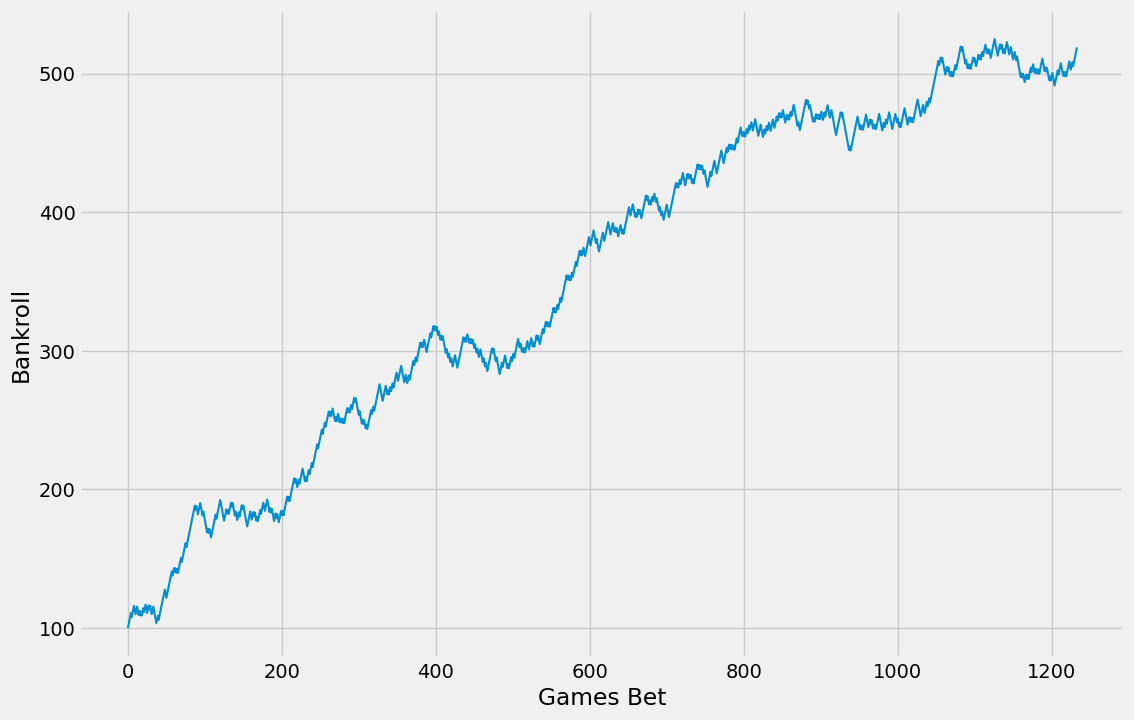

min balance: 102.72727272727273 
max balance: 524.9090909090999 
final balance: 521.6363636363737 
win percentage 58.35 
profit: 421.6363636363635 risk: 3702.0 
ROI: 11.39


(      index   SEASON HOME_TEAM_ABBREVIATION            GAME_DATE     GAME_ID  \
 0      9729  2021-22                    LAL  2021-10-22 00:00:00  0022100025   
 1      9728  2021-22                    DEN  2021-10-22 00:00:00  0022100024   
 2      9727  2021-22                    HOU  2021-10-22 00:00:00  0022100023   
 3      9726  2021-22                    CHI  2021-10-22 00:00:00  0022100022   
 4      9730  2021-22                    SAC  2021-10-22 00:00:00  0022100026   
 ...     ...      ...                    ...                  ...         ...   
 1229  10950  2021-22                    GSW  2022-06-05 00:00:00  0042100402   
 1230  10951  2021-22                    BOS  2022-06-08 00:00:00  0042100403   
 1231  10952  2021-22                    BOS  2022-06-10 00:00:00  0042100404   
 1232  10953  2021-22                    GSW  2022-06-13 00:00:00  0042100405   
 1233  10954  2021-22                    BOS  2022-06-16 00:00:00  0042100406   
 
           MATCHUP  HOME_H

In [22]:
simulate_bets_1(df_sgd_selected_bets, unit_size=3)

In [29]:
df_sgd_selected_bets[['HOME_TEAM_ABBREVIATION', 'MATCHUP', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'HOME_SCORE_PRED', 'AWAY_SCORE_PRED']].head(20)

,HOME_TEAM_ABBREVIATION,MATCHUP,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,HOME_SCORE_PRED,AWAY_SCORE_PRED
9729,LAL,LAL vs. PHX,105,115,101.409106,106.195191
9728,DEN,DEN vs. SAS,102,96,119.125615,113.264314
9727,HOU,HOU vs. OKC,124,91,118.108227,108.858291
9726,CHI,CHI vs. NOP,128,112,112.328137,104.627422
9730,SAC,SAC vs. UTA,101,110,110.267397,111.673057
9724,BOS,BOS vs. TOR,83,115,111.706785,110.630277
9723,WAS,WAS vs. IND,135,134,116.696698,125.644524
9722,ORL,ORL vs. NYK,96,121,94.802839,103.981064
9721,CLE,CLE vs. CHA,112,123,114.231737,116.522946
9725,PHI,PHI vs. BKN,109,114,110.523665,108.128731


In [28]:
sgd_preds[['HOME_TEAM_ABBREVIATION', 'MATCHUP', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'HOME_SCORE_PRED', 'AWAY_SCORE_PRED']].head(20)

,HOME_TEAM_ABBREVIATION,MATCHUP,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,HOME_SCORE_PRED,AWAY_SCORE_PRED
0,LAL,LAL vs. PHX,105,115,97.196346,104.648777
1,DEN,DEN vs. SAS,102,96,117.205307,113.625334
2,HOU,HOU vs. OKC,124,91,117.503751,104.458620
3,CHI,CHI vs. NOP,128,112,115.026841,102.441450
4,SAC,SAC vs. UTA,101,110,110.616742,109.058593
5,BOS,BOS vs. TOR,83,115,109.327167,112.588914
6,WAS,WAS vs. IND,135,134,116.580948,127.422853
7,ORL,ORL vs. NYK,96,121,91.693906,100.877446
8,CLE,CLE vs. CHA,112,123,109.261717,115.928418
9,PHI,PHI vs. BKN,109,114,111.162562,106.539837


In [363]:
def season_to_string(x):
    return str(x) + '-' + str(x+1)[-2:]

def get_data_from_db(target, db_filepath, test_season):
    
        
    test_season_str = season_to_string(test_season)
    
    connection = sqlite3.connect(db_filepath)

    df = pd.read_sql('SELECT * FROM team_stats_ewa_matchup_dev', con=connection)
    df = df.drop(columns=['index'])
    connection.close()

    df = df.sort_values('GAME_DATE')

    df = df.dropna()

    columns_to_drop = ['SEASON', 'HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'GAME_ID', 'MATCHUP',
                        'HOME_HOME_GAME', 'HOME_TEAM_SCORE', 'HOME_ML', 'HOME_SPREAD',
                        'HOME_ATS_DIFF', 'HOME_TEAM_COVERED', 'HOME_POINT_DIFF',
                        'HOME_WL', 'AWAY_ML', 'AWAY_TEAM_SCORE',
                        'HOME_PTS_L5', 'HOME_PTS_L10', 'HOME_PTS_L20',
                        'HOME_PLUS_MINUS_L5', 'HOME_PLUS_MINUS_L10', 'HOME_PLUS_MINUS_L20',
                        'HOME_NET_RATING_L5', 'HOME_NET_RATING_L10', 'HOME_NET_RATING_L20',
                        'HOME_POSS_L5', 'HOME_POSS_L10', 'HOME_POSS_L20',
                        'HOME_PTS_opp_L5', 'HOME_PTS_opp_L10', 'HOME_PTS_opp_L20',
                        'HOME_PLUS_MINUS_opp_L5', 'HOME_PLUS_MINUS_opp_L10', 'HOME_PLUS_MINUS_opp_L20',
                        'HOME_NET_RATING_opp_L5', 'HOME_NET_RATING_opp_L10', 'HOME_NET_RATING_opp_L20',
                        'HOME_POSS_opp_L5', 'HOME_POSS_opp_L10', 'HOME_POSS_opp_L20',
                        'HOME_REB_L5', 'HOME_REB_L10', 'HOME_REB_L20',  
                        'HOME_REB_opp_L5', 'HOME_REB_opp_L10', 'HOME_REB_opp_L20',       
                        'AWAY_PTS_L5', 'AWAY_PTS_L10', 'AWAY_PTS_L20',
                        'AWAY_PLUS_MINUS_L5', 'AWAY_PLUS_MINUS_L10', 'AWAY_PLUS_MINUS_L20',
                        'AWAY_NET_RATING_L5', 'AWAY_NET_RATING_L10', 'AWAY_NET_RATING_L20',
                        'AWAY_POSS_L5', 'AWAY_POSS_L10', 'AWAY_POSS_L20',
                        'AWAY_PTS_opp_L5', 'AWAY_PTS_opp_L10', 'AWAY_PTS_opp_L20',
                        'AWAY_PLUS_MINUS_opp_L5', 'AWAY_PLUS_MINUS_opp_L10', 'AWAY_PLUS_MINUS_opp_L20',
                        'AWAY_NET_RATING_opp_L5', 'AWAY_NET_RATING_opp_L10', 'AWAY_NET_RATING_opp_L20',
                        'AWAY_POSS_opp_L5', 'AWAY_POSS_opp_L10', 'AWAY_POSS_opp_L20',
                        'AWAY_REB_L5', 'AWAY_REB_L10', 'AWAY_REB_L20',
                        'AWAY_REB_opp_L5', 'AWAY_REB_opp_L10', 'AWAY_REB_opp_L20']

    train_df = df.loc[df['SEASON'] < test_season_str]
    test_df = df.loc[df['SEASON'] >= test_season_str]

    X_train = train_df.drop(columns=columns_to_drop)
    y_train = train_df[target]

    X_test = test_df.drop(columns=columns_to_drop)
    y_test = test_df[target]
    
    return X_train, X_test, y_train, y_test, train_df, test_df
    
    
def tscv_by_season(train_df, test_season = 2021):
    earliest_year_with_data = 2013
    min_training_years = 3

    cv_splits = []

    for year in range(earliest_year_with_data + min_training_years, test_season):      
        listTrain = train_df.loc[train_df['SEASON'] < season_to_string(year)].index
        listVal = train_df.loc[train_df['SEASON'] == season_to_string(year)].index        
        cv_splits.append((listTrain, listVal))

    return cv_splits      

        
def objective(trial):
    
    sgd_alpha = trial.suggest_float('alpha', 1e-4, 1e2, log=True)
    sgd_l1_ratio = trial.suggest_float('l1_ratio', 0.4, 0.95, log=False)
    sgd_epsilon = trial.suggest_float('epsilon', 5, 25, log=False)
    sgd_loss = trial.suggest_categorical('loss', ['squared_error', 'huber', 'epsilon_insensitive'])
        
    regressor_obj = Pipeline([('scaler', StandardScaler()),
                                ('sgd', MultiOutputRegressor(
                                            SGDRegressor(loss = sgd_loss,
                                                        alpha = sgd_alpha,
                                                        epsilon = sgd_epsilon,
                                                        penalty = 'elasticnet',
                                                        max_iter = 10000,
                                                        l1_ratio = sgd_l1_ratio,
                                                        shuffle = False,
                                                        random_state = 23)
                                            )
                                 )
                                ]
                             )
    
    score = cross_val_score(regressor_obj, X_train, y_train, cv = cv_splits, scoring = 'neg_mean_absolute_error', error_score='raise')
    
    score_avg = score.mean()
    
    return score_avg




In [364]:
X_train, X_test, y_train, y_test, train_df, test_df = get_data_from_db(target=['HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE'], db_filepath=db_filepath, test_season=2021)


In [388]:
df1 = test_df.loc[test_df['SEASON'] == '2021-22'].reset_index(drop=True)
df2 = df.loc[df['SEASON'] == '2021-22'].reset_index(drop=True)

In [378]:
df1shape, df2.shape

((1234, 645), (1234, 645))

In [393]:
df2

,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_HOME_GAME,HOME_TEAM_SCORE,HOME_ML,HOME_SPREAD,HOME_ATS_DIFF,...,AWAY_EFG_PCT_L20,AWAY_EFG_PCT_opp_L20,AWAY_AST_RATIO_L20,AWAY_AST_RATIO_opp_L20,AWAY_TOV_PCT_L20,AWAY_TOV_PCT_opp_L20,AWAY_PIE_L20,AWAY_REST,AWAY_Threein4B2B,AWAY_Threein4
0,2021-22,SAC,2021-10-22 00:00:00,0022100026,SAC vs. UTA,1,101,2.900000,5.5,-3.5,...,0.564101,0.541909,21.390861,22.837707,12.443232,10.360483,0.500093,2.0,0,0
1,2021-22,LAL,2021-10-22 00:00:00,0022100025,LAL vs. PHX,1,105,1.909091,-3.5,-13.5,...,0.547375,0.531037,24.004109,23.521182,11.868763,11.349343,0.507230,2.0,0,0
2,2021-22,DEN,2021-10-22 00:00:00,0022100024,DEN vs. SAS,1,102,1.357143,-7.0,-1.0,...,0.516743,0.549170,25.099453,25.871686,9.667264,10.914209,0.483864,2.0,0,0
3,2021-22,HOU,2021-10-22 00:00:00,0022100023,HOU vs. OKC,1,124,1.800000,-1.5,31.5,...,0.471148,0.559651,19.730972,25.040270,14.257521,11.198332,0.405304,2.0,0,0
4,2021-22,CHI,2021-10-22 00:00:00,0022100022,CHI vs. NOP,1,128,1.370370,-7.0,9.0,...,0.505586,0.543344,24.548536,24.511467,12.620465,12.020979,0.483456,2.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,2021-22,GSW,2022-06-05 00:00:00,0042100402,GSW vs. BOS,1,107,1.500000,-5.5,13.5,...,0.540573,0.488369,27.669554,22.351466,13.157609,11.832998,0.556072,3.0,0,0
1230,2021-22,BOS,2022-06-08 00:00:00,0042100403,BOS vs. GSW,1,116,1.598802,-3.5,12.5,...,0.556508,0.527021,28.984041,25.395308,12.951646,11.614440,0.529838,3.0,0,0
1231,2021-22,BOS,2022-06-10 00:00:00,0042100404,BOS vs. GSW,1,97,1.549451,-4.0,-14.0,...,0.560760,0.529988,28.581737,25.946567,13.299030,11.527961,0.518848,2.0,0,0
1232,2021-22,GSW,2022-06-13 00:00:00,0042100405,GSW vs. BOS,1,104,1.549451,-4.0,6.0,...,0.535233,0.501140,27.428046,22.796663,13.439355,12.411245,0.538944,3.0,0,0


In [392]:
df1.eq(df2)

,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_HOME_GAME,HOME_TEAM_SCORE,HOME_ML,HOME_SPREAD,HOME_ATS_DIFF,...,AWAY_EFG_PCT_L20,AWAY_EFG_PCT_opp_L20,AWAY_AST_RATIO_L20,AWAY_AST_RATIO_opp_L20,AWAY_TOV_PCT_L20,AWAY_TOV_PCT_opp_L20,AWAY_PIE_L20,AWAY_REST,AWAY_Threein4B2B,AWAY_Threein4
0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1230,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1231,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1232,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [399]:
df1.loc[~(df1.eq(df2).all(axis=1))].sort_values(['GAME_ID'])

,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_HOME_GAME,HOME_TEAM_SCORE,HOME_ML,HOME_SPREAD,HOME_ATS_DIFF,...,AWAY_EFG_PCT_L20,AWAY_EFG_PCT_opp_L20,AWAY_AST_RATIO_L20,AWAY_AST_RATIO_opp_L20,AWAY_TOV_PCT_L20,AWAY_TOV_PCT_opp_L20,AWAY_PIE_L20,AWAY_REST,AWAY_Threein4B2B,AWAY_Threein4
13,2021-22,MIN,2021-10-23 00:00:00,0022100031,MIN vs. NOP,1,96,1.333333,-9.5,-2.5,...,0.505579,0.549232,24.544609,25.052247,12.863009,12.045571,0.475281,1.0,1,0
12,2021-22,SAS,2021-10-23 00:00:00,0022100032,SAS vs. MIL,1,111,3.100000,6.0,-4.0,...,0.523562,0.546102,23.507742,21.929689,10.729675,11.991899,0.512467,2.0,0,0
10,2021-22,POR,2021-10-23 00:00:00,0022100033,POR vs. PHX,1,134,1.666667,-3.0,26.0,...,0.549073,0.526628,24.634514,23.618553,11.774815,11.599206,0.515476,1.0,1,0
11,2021-22,LAC,2021-10-23 00:00:00,0022100034,LAC vs. MEM,1,114,1.555556,-4.0,-10.0,...,0.529937,0.548699,25.160829,25.285585,10.714833,11.655411,0.498180,3.0,0,0
28,2021-22,CHA,2021-10-25 00:00:00,0022100041,CHA vs. BOS,1,129,1.909091,1.0,-10.0,...,0.524518,0.546899,23.623722,24.360336,12.625844,12.165885,0.466533,1.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,2021-22,DEN,2022-04-24 00:00:00,0042100164,DEN vs. GSW,1,126,2.700000,5.0,10.0,...,0.586665,0.515805,29.042374,24.256920,12.990314,12.423306,0.538320,3.0,0,0
1167,2021-22,UTA,2022-04-21 00:00:00,0042100173,UTA vs. DAL,1,118,1.222222,-8.5,-16.5,...,0.571159,0.520753,25.959222,25.393820,10.699399,10.796335,0.520228,3.0,0,0
1188,2021-22,UTA,2022-04-28 00:00:00,0042100176,UTA vs. DAL,1,96,2.110000,1.0,-1.0,...,0.559330,0.511961,24.781016,23.771757,10.625240,10.971920,0.525985,3.0,0,0
1190,2021-22,BOS,2022-05-01 00:00:00,0042100211,BOS vs. MIL,1,89,1.500000,-5.0,-17.0,...,0.553200,0.526279,24.116418,25.741744,12.097093,11.454329,0.528635,4.0,0,0


In [401]:
df2.loc[~(df1.eq(df2).all(axis=1))].sort_values(['GAME_ID'])

,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_HOME_GAME,HOME_TEAM_SCORE,HOME_ML,HOME_SPREAD,HOME_ATS_DIFF,...,AWAY_EFG_PCT_L20,AWAY_EFG_PCT_opp_L20,AWAY_AST_RATIO_L20,AWAY_AST_RATIO_opp_L20,AWAY_TOV_PCT_L20,AWAY_TOV_PCT_opp_L20,AWAY_PIE_L20,AWAY_REST,AWAY_Threein4B2B,AWAY_Threein4
12,2021-22,MIN,2021-10-23 00:00:00,0022100031,MIN vs. NOP,1,96,1.333333,-9.5,-2.5,...,0.505579,0.549232,24.544609,25.052247,12.863009,12.045571,0.475281,1.0,1,0
13,2021-22,SAS,2021-10-23 00:00:00,0022100032,SAS vs. MIL,1,111,3.100000,6.0,-4.0,...,0.523562,0.546102,23.507742,21.929689,10.729675,11.991899,0.512467,2.0,0,0
11,2021-22,POR,2021-10-23 00:00:00,0022100033,POR vs. PHX,1,134,1.666667,-3.0,26.0,...,0.549073,0.526628,24.634514,23.618553,11.774815,11.599206,0.515476,1.0,1,0
10,2021-22,LAC,2021-10-23 00:00:00,0022100034,LAC vs. MEM,1,114,1.555556,-4.0,-10.0,...,0.529937,0.548699,25.160829,25.285585,10.714833,11.655411,0.498180,3.0,0,0
31,2021-22,CHA,2021-10-25 00:00:00,0022100041,CHA vs. BOS,1,129,1.909091,1.0,-10.0,...,0.524518,0.546899,23.623722,24.360336,12.625844,12.165885,0.466533,1.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,2021-22,DEN,2022-04-24 00:00:00,0042100164,DEN vs. GSW,1,126,2.700000,5.0,10.0,...,0.586665,0.515805,29.042374,24.256920,12.990314,12.423306,0.538320,3.0,0,0
1169,2021-22,UTA,2022-04-21 00:00:00,0042100173,UTA vs. DAL,1,118,1.222222,-8.5,-16.5,...,0.571159,0.520753,25.959222,25.393820,10.699399,10.796335,0.520228,3.0,0,0
1187,2021-22,UTA,2022-04-28 00:00:00,0042100176,UTA vs. DAL,1,96,2.110000,1.0,-1.0,...,0.559330,0.511961,24.781016,23.771757,10.625240,10.971920,0.525985,3.0,0,0
1191,2021-22,BOS,2022-05-01 00:00:00,0042100211,BOS vs. MIL,1,89,1.500000,-5.0,-17.0,...,0.553200,0.526279,24.116418,25.741744,12.097093,11.454329,0.528635,4.0,0,0
